In [31]:
from os.path import join as joinpath
from glob import glob

import torch
import pandas as pd

from IPython import display
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 13

In [2]:
pattern_tags = [
    ('./log/cifar10_vit_1.0/alg/find_lr/spsa_sgd_*_*/ckpt.pth', 'spsa_sgd'),
    ('./log/cifar10_vit_1.0/alg/find_lr/spsa_nag_*_*/ckpt.pth', 'spsa_nag'),
    ('./log/cifar10_vit_1.0/alg/find_lr/spsa_adam_*_*/ckpt.pth', 'spsa_adam'),
]

tag_power_fr = {}
for pattern, tag in pattern_tags:
    paths = sorted(glob(pattern))
    for path in paths:
        power_idx = path.find(tag) + len(tag) + 1
        power = path[power_idx:power_idx+2]
        with open('temp.txt', 'ta') as file:
            print(tag, power, path, file=file)
        ckpts = torch.load(path)
        fr = ckpts['fr']
        
        key = (tag, power)
        if key in tag_power_fr:
            tag_power_fr[key].append(fr)
        else:
            tag_power_fr[key] = [fr]

table = []
for key in tag_power_fr.keys():
    fr_list = torch.tensor(tag_power_fr[key])
    std, mean = torch.std_mean(fr_list)
    count = len(fr_list)
    
    tag = key[0]
    lr = f'1.0E{key[1]}'
    
    table.append((tag, lr, mean.item(), std.item(), count))
    
df = pd.DataFrame(table, columns=('Algorithm', 'LR', 'FR mean', 'FR std', '# exp'))
display.display(df)

,Algorithm,LR,FR mean,FR std,# exp
0,spsa_sgd,1.0E-1,10.470000,0.697264,10
1,spsa_sgd,1.0E-2,17.688999,3.977468,10
2,spsa_sgd,1.0E-3,33.221001,6.536767,10
3,spsa_sgd,1.0E-4,1.674000,0.119648,10
4,spsa_nag,1.0E-1,25.290001,4.608335,10
5,spsa_nag,1.0E-2,27.375999,3.643899,10
6,spsa_nag,1.0E-3,29.534000,3.752914,10
7,spsa_nag,1.0E-4,37.139000,2.973369,10
8,spsa_nag,1.0E-5,44.630001,4.716783,10
9,spsa_nag,1.0E-6,25.365999,4.318454,10


In [3]:
def bar_from_table(ax, mean, std, columns=None, legend=None, 
                   column_width=0.9, bar_padding=0.1, cmap='tab10'):
    num_bars, num_columns = mean.shape
    bar_width = column_width / num_bars
    
    right = 0.5 * (column_width - bar_width)
    left = -right
    
    bar_width *= (1 - bar_padding)
    centers = torch.arange(num_columns).float()
    offsets = torch.linspace(left, right, num_bars)
    
    cmap = cm.get_cmap(cmap)
    for i, (row_mean, row_std) in enumerate(zip(mean, std)):
        ax.bar(centers + offsets[i], row_mean, yerr=row_std, 
               width=bar_width, capsize=20 * bar_width, color=cmap(i))
    ax.set_ylabel('ASR (%)')
        
    if columns:
        ax.set_xticks(centers, columns)
    else:
        ax.set_xticks(centers, (centers.int() + 1).tolist())
        
    if legend:
        ax.legend(legend)

[ResNet18]


,Algorithm,ASR (%) mean,ASR (%) std,l2-norm,# exp
0,RGF,81.539001,0.684389,382.666443,20
1,RGF+Adam,80.855499,0.664004,374.750549,20
2,SPSA,87.401497,0.222764,433.427155,20
3,SPSA-GC,83.434502,0.375030,437.224121,20
4,SPSA-AM (ours),85.961998,0.180192,408.272522,20


[ViT]


,Algorithm,ASR (%) mean,ASR (%) std,l2-norm,# exp
0,RGF,44.865002,2.178176,369.928528,10
1,RGF+Adam,40.737000,0.986476,355.989410,10
2,SPSA,58.985001,5.414708,420.890564,10
3,SPSA-GC,50.075001,0.483145,434.950531,10
4,SPSA-AM (ours),57.678001,0.487535,405.038086,20


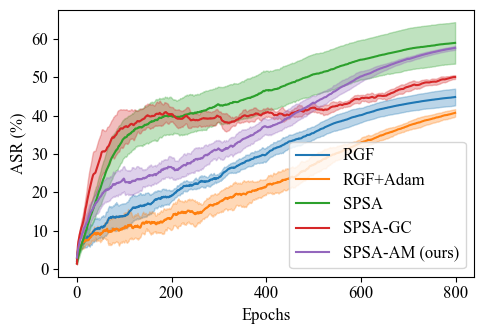

In [40]:
tags = ['RGF_SGD',  'RGF_Adam', 'SPSA_SGD', 'SPSA_NAG', 'SPSA_Adam']
algs = ['RGF',      'RGF+Adam', 'SPSA',     'SPSA-GC',  'SPSA-AM (ours)']

def make_dataframe(arch: str):
    root = f'./log/cifar10_{arch.lower()}_1.0/alg'
    table = []
    std_list, mean_list = [], []
    for tag, alg in zip(tags, algs):
        ckpt_filenames = sorted(glob(joinpath(root, tag.lower(), '*', 'ckpt.pth')))
        ckpts = [torch.load(fn) for fn in ckpt_filenames]
        
        fr_list = []
        for ckpt in ckpts:
            short = 800 - len(ckpt['fr_list'])
            fr_list.append(ckpt['fr_list'] + ([ckpt['fr_list'][-1]] * short))
        fr_list = torch.tensor(fr_list)
        std, mean = torch.std_mean(fr_list, dim=0)
        
        uaps = torch.cat([ckpt['uap'] for ckpt in ckpts], dim=0)
        norm = torch.norm(uaps * 255.0, p=2, dim=(1, 2, 3))
        norm = torch.mean(norm)

        std_list.append(std)
        mean_list.append(mean)
        table.append((alg, mean[-1].item(), std[-1].item(), norm.item(), len(ckpts)))
        df = pd.DataFrame(table, columns=('Algorithm', 'ASR (%) mean', 'ASR (%) std', 'l2-norm', '# exp'))
    return table, df, std_list, mean_list


arch_list = ['ResNet18', 'ViT']
arch_plot_idx = 1
std = 1.0
title_pos = -0.35

# table, df, std_list, mean_list
info = [make_dataframe(arch) for arch in arch_list]

#region display
for arch, (_, df, _, _) in zip(arch_list, info):
    print(f'[{arch}]')
    display.display(df)

algs_x = range(len(table))
epochs_x = range(len(info[0][3][0]))
plt.figure(figsize=(5, 3.5))

# Draw bar chart
# ax = plt.subplot(121)
# if title_pos != None:
#     plt.title('(a) ASR over Optimization Algorithms', y=title_pos)
# mean_table, std_table = [], []
# for i in info:
#     for row in i[0]:
#         mean_table.append(row[1])
#         std_table.append(row[2])
# mean_table = torch.tensor(mean_table).view(len(arch_list), -1)
# std_table = torch.tensor(std_table).view(len(arch_list), -1)

# plot_kwargs = dict(
#     column_width=0.9, 
#     bar_padding=0.1,
#     cmap='Pastel1',
# )
# bar_from_table(ax=ax, mean=mean_table, std=std_table, columns=algs, legend=arch_list, **plot_kwargs)
# ax.set_xlabel('Algorithms')

# Draw epoch plot
_, _, std_list, mean_list = info[arch_plot_idx]
ax = plt.subplot(111)
# if title_pos != None:
#     plt.title(f'(b) ASR against {arch_list[arch_plot_idx]} over Optimization Algorithms', y=title_pos)
plots = []
for best_means, best_stds in zip(mean_list, std_list):
    plots.append(ax.plot(epochs_x, best_means))
for best_means, best_stds in zip(mean_list, std_list):
    best_stds *= std
    ax.fill_between(epochs_x, best_means - best_stds, best_means + best_stds, 
                    alpha=0.3, edgecolor='face', linewidth=1, linestyle='-', antialiased=True)
ax.legend(algs)
ax.set_xlabel('Epochs')
ax.set_ylabel('ASR (%)')

matplotlib.rcParams['font.size'] = 12
plt.tight_layout()
plt.savefig('temp/algs.pdf')
plt.show()
#endregion